Allison Aprile<br>
CS-584 A<br>
March 1, 2021<br>
HW1<br>

# **Modeling and Evaluation**

In [62]:
# Imports
from google.colab import drive
import pandas as pd
import math
import numpy as np
from keras.utils import to_categorical
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import KFold, train_test_split
from statistics import mean
import sys
import matplotlib.pyplot as plt

In [63]:
# Mount drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## <font color=navy>**Build classifiers**

### Cross-Entropy Loss Functions (for later Evaluation)

In [3]:
def cross_entropy_loss_lr(X, y_oh, w):
  # Initialize loss
  loss = 0

  # Create exponents array
  expons = np.exp(w.dot(X.T))

  # Convert y_oh to vector
  y = y_oh.argmax(axis=1) + 1

  # Iterate through the classes and update loss
  for k in range(y_oh.shape[1]):
    
    # Calculate loss for all samples given k 
    loss += y.dot(np.log(expons[k] / np.sum(expons, axis=0)))
  
  # Take negative average
  loss *= (-1/X.shape[0])

  # Return loss
  return loss

In [64]:
def cross_entropy_loss_mlp(X, y_oh, hidden_weights, output_weights):
  # Get prediction vector
  pred = predict_mlp(X, hidden_weights, output_weights)

  # Convert y_oh to vector
  y = y_oh.argmax(axis=1) + 1

  # Calculate loss
  loss = y.T.dot(np.log(pred))
  
  # Take negative average
  loss *= (-1/X.shape[0])
  
  # Return loss
  return loss

### Logistic Regression with L2 Regularization (Mini-Batch Gradient Descent)

In [5]:
def fit_logistic_mbgd(X_train, y_train_oh, X_val, y_val_oh, batch_size, epochs, learning_rate, lam):
  # Add bias (x0 = 1) to each training/validation sample
  bias = np.ones((X_train.shape[0], 1))
  v_bias = np.ones((X_val.shape[0], 1))
  X_bias = np.append(bias, X_train, axis=1)
  val_bias = np.append(v_bias, X_val, axis=1)

  # Loss lists
  train_loss = [0]
  val_loss = [0]

  # Initialize w - shape num_classes x num_features
  w = np.random.randn(4, X_bias.shape[1])

  # Perform mini-batch gradient descent
  for e in range(epochs):
    sys.stdout.flush()
    sys.stdout.write('\rEpoch: ' + str(e))
    
    # Shuffle data
    X_bias, y_train_oh = shuffle(X_bias, y_train_oh)

    # Take first batch_size elements as current batch (random sampled since shuffled data)
    X_batch = X_bias[:batch_size]
    y_batch = y_train_oh[:batch_size]

    # Compute Wx (for softmax denominator/numerator)
    expons = np.exp(w.dot(X_batch.T))

    # Define gradient matrix
    gradient = np.ndarray(w.shape)

    # Calculate gradient for each wk
    for k in range(y_train_oh.shape[1]):
      # Get l2 regularization term
      l2 = 2 * lam * w[k]

      # Calculate gradient (using derivative of defined function J)
      gradient[k, :] = (1/batch_size)*(((expons[k] / np.sum(expons, axis=0)) - y_batch[:, k]).dot(X_batch) + l2)

    # Update w
    w = w - learning_rate * gradient

    # Calculate loss
    train_loss.append(cross_entropy_loss_lr(X_bias, y_train_oh, w))
    val_loss.append(cross_entropy_loss_lr(val_bias, y_val_oh, w))

  return w, train_loss, val_loss

### Logistic Regression with L2 Regularization (Stochastic Gradient Descent)

In [6]:
def fit_logistic_sgd(X_train, y_train_oh, X_val, y_val_oh, epochs, learning_rate, lam):
  # Add bias (x0 = 1) to each training example
  bias = np.ones((X_train.shape[0], 1))
  v_bias = np.ones((X_val.shape[0], 1))
  X_bias = np.append(bias, X_train, axis=1)
  val_bias = np.append(v_bias, X_val, axis=1)

  # Loss lists
  train_loss = [0]
  val_loss = [0]

  # Initialize w - shape num_classes x num_features
  w = np.random.randn(4, X_bias.shape[1])

  for e in range(epochs):
    sys.stdout.flush()
    sys.stdout.write('\rEpoch: ' + str(e + 1))
  
    # Shuffle data
    X_bias, y_train_oh = shuffle(X_bias, y_train_oh)

    # Perform SGD
    for i in range(len(X_bias)):
      
      # Select one random index
      ind = np.random.randint(0, len(X_bias))

      # Retrieve random sample
      x_sample = X_bias[ind:ind+1]
      y_sample = y_train_oh[ind:ind+1]

      # Compute Wx (for softmax denominator/numerator)
      expons = np.exp(w.dot(x_sample.T))

      # Define gradient matrix
      gradient = np.ndarray(w.shape)

      # Calculate gradient for each wk
      for k in range(y_train_oh.shape[1]):
        # Get l2 regularization term 
        l2 = 2 * lam * w[k]

        # Calculate gradient (using derivative of defined function J)
        gradient[k, :] = ((((expons[k][0] / np.sum(expons, axis=0)) - y_sample[0][k])*x_sample.T) + l2.reshape((X_bias.shape[1], 1))).reshape(gradient[k,:].shape)
      
      # Update w
      w = w - learning_rate * gradient

      # Calculate loss - Gets stuck here!
      #train_loss.append(cross_entropy_loss_lr(X_bias, y_train_oh, w))
      #val_loss.append(cross_entropy_loss_lr(val_bias, y_val_oh, w))

  return w#, train_loss, val_loss

In [7]:
# Logistic prediction function
def predict_logistic(X, w):
  # Add bias (x0 = 1) to each training example
  bias = np.ones((X.shape[0], 1))
  X_bias = np.append(bias, X, axis=1)

  # Get prediction array (probabilities)
  pred = X_bias.dot(w.T)

  # Get prediction vector (classes)
  pred_vec = np.argmax(pred, axis=1)

  # Update and return
  return pred_vec + np.ones(pred_vec.shape)

### Multilayer Perceptron (ML) with One Hidden Layer

In [65]:
def forward_pass(hidden_weights, output_weights, X_bias):
  # Get hidden activation matrix
  z1 = hidden_weights.dot(X_bias.T)

  # Get hidden layer neuron outputs (sigmoid)
  h1 = 1 / (np.ones(z1.shape) + np.exp(-1*z1))

  # Get output activation matrix
  z2 = output_weights.dot(h1)

  # Get output layer neuron outputs (probabilities - softmax)
  h2 = np.exp(z2) / np.sum(np.exp(z2), axis=0)

  # Get prediction
  preds = np.argmax(h2, axis=0)
  preds = preds + np.ones(preds.shape)

  # Convert to one-hot-vector
  preds_oh = to_categorical(preds)[:, -4:]

  return z1, h1, z2, h2, preds_oh

In [66]:
def fit_mlp(X_train, y_train_oh, X_val, y_val_oh, batch_size, num_hidden_neurons, learning_rate, epochs):
  # Add bias (x0 = 1) to each training example
  bias = np.ones((X_train.shape[0], 1))
  v_bias = np.ones((X_val.shape[0], 1))
  X_bias = np.append(bias, X_train, axis=1)
  val_bias = np.append(v_bias, X_val, axis=1)

  # Loss lists
  train_loss = [0]
  val_loss = [0]

  # Initialize hidden weights array - shape num_hidden_neurons x num_features_X_bias
  hidden_weights = np.random.randn(num_hidden_neurons, X_bias.shape[1])

  # Initialize output weights array - shape num_classes x num_hidden_neurons
  output_weights = np.random.randn(y_train_oh.shape[1], num_hidden_neurons)

  # Perform mini-batch gradient descent
  for e in range(epochs):
    sys.stdout.flush()
    sys.stdout.write('\rEpoch: ' + str(e + 1))
    
    # Shuffle data
    X_bias, y_train_oh = shuffle(X_bias, y_train_oh)

    # Take first batch_size elements as current batch (random sampled since shuffled data)
    X_batch = X_bias[:batch_size]
    y_batch = y_train_oh[:batch_size]
  
    ''' Forward pass '''
    z1, h1, z2, h2, preds_oh = forward_pass(hidden_weights, output_weights, X_batch)

    # For some reason, this part was giving me errors on random batches during
    # training. For that reason, I put in this if statement
    if preds_oh.shape == y_batch.shape:
      ''' Compute gradients of J with respect to parameters
      and implement backpropagation, using same cross-entropy loss
      without l2 regularization '''
      # Gradients
      dz2 = preds_oh.T - y_batch.T
      dw2 = dz2.dot(h1.T)
      dz1 = output_weights.T.dot(dz2)*h1*(np.ones(h1.shape) - h1)
      dw1 = dz1.dot(X_batch)

      # Update values
      hidden_weights = hidden_weights - learning_rate*dw1
      output_weights = output_weights - learning_rate*dw2

    # Calculate loss
    train_loss.append(cross_entropy_loss_mlp(X_bias, y_train_oh, hidden_weights, output_weights))
    val_loss.append(cross_entropy_loss_mlp(val_bias, y_val_oh, hidden_weights, output_weights))

  ''' Define network dictionary '''
  network = [
             {'layer': 'input', 
              'shape': X_bias.shape[1],
              'weights': None},
             
             {'layer': 'hidden1',
              'shape': hidden_weights.shape,
              'weights': hidden_weights},
             
             {'layer': 'output',
              'shape': output_weights.shape,
              'weights': output_weights},
             
             {'num_hidden_neurons': num_hidden_neurons,
              'learning_rate': learning_rate,
              'epochs': epochs}
  ]

  return network, hidden_weights, output_weights, train_loss, val_loss


In [67]:
def predict_mlp(X, hidden_weights, output_weights):
  if X.shape[1] != hidden_weights.shape[1]:
    # Add bias (x0 = 1) to each training example
    bias = np.ones((X.shape[0], 1))
    X = np.append(bias, X, axis=1)

  # Get hidden activation matrix
  z1 = hidden_weights.dot(X.T)

  # Get hidden layer neuron outputs (sigmoid)
  h1 = 1 / (np.ones(z1.shape) + np.exp(-1*z1))

  # Get output activation matrix
  z2 = output_weights.dot(h1)

  # Get output layer neuron outputs (probabilities - softmax)
  h2 = np.exp(z2) / np.sum(np.exp(z2), axis=0)

  # Get prediction
  preds = np.argmax(h2, axis=0)
  preds = preds + np.ones(preds.shape)

  return preds

## <font color=navy>**Load data** (preprocessed in Aprile_HW1_Preprocessing.ipynb)

In [11]:
# Load training data
X_train = np.load('/content/drive/My Drive/X_train.npy')
y_train = np.load('/content/drive/My Drive/y_train.npy')
y_train_oh = np.load('/content/drive/My Drive/y_train_oh.npy')

# Confirm shapes
print(X_train.shape)
print(y_train.shape)
print(y_train_oh.shape)

(120000, 4576)
(120000,)
(120000, 4)


In [12]:
# Load testing data
X_test = np.load('/content/drive/My Drive/X_test.npy')
y_test = np.load('/content/drive/My Drive/y_test.npy')
y_test_oh = np.load('/content/drive/My Drive/y_test_oh.npy')

# Confirm shapes
print(X_test.shape)
print(y_test.shape)
print(y_test_oh.shape)

(7600, 4576)
(7600,)
(7600, 4)


## <font color=navy>**Cross-validation (Hyperparameter Tuning)**

In [12]:
# Define parameters to test (BECAUSE OF SLOW COMPUTE TIMES/CRASHING RAM, ONLY DID A FEW!)
learning_rate = 0.01
epochs = 50
batch_size = 100

lam = [0.001, 0.01, 0.1]
num_hidden_neurons = [10, 50, 100]


In [13]:
# Split data
# Define data splitter (into k=5 folds)
splits = KFold(n_splits=5, shuffle=True)


### Logistic Regression (Mini-Batch)

In [15]:
# 5-fold cross-validation
for l in lam:
  # Print current parameters
  print("Training: Lambda = ", l)

  # Get average of all training/validation losses
  train_l = []
  val_l = []

  for train_ind, val_ind in splits.split(X_train):
    # Define training and validation sets
    X_train_2, X_val = X_train[train_ind, :], X_train[val_ind, :]
    y_train_oh_2, y_val_oh = y_train_oh[train_ind], y_train_oh[val_ind]

    # Train model
    w, train_loss, val_loss = fit_logistic_mbgd(X_train_2, y_train_oh_2, X_val, y_val_oh, batch_size, epochs, learning_rate, l)
    
    # Append train and validation losses for final average
    train_l.append(train_loss[-1])
    val_l.append(val_loss[-1])
  
  if len(train_l) > 0 and len(val_l) > 0:
    print("\tAverage training loss: ", mean(train_l))
    print("\tAverage validation loss: ", mean(val_l))
    print()

Training: Lambda =  0.001
	Average training loss:  22.354572751614278
	Average validation loss:  22.349300439127564

Training: Lambda =  0.01
	Average training loss:  18.309685931889017
	Average validation loss:  18.315728956776066

Training: Lambda =  0.1
	Average training loss:  18.517605182657906
	Average validation loss:  18.513674660950382



<font color=maroon>**Based on the average validation loss, the best value for lambda is 0.01.**

### Logistic Regression (SGD)

In [21]:
# 5-fold cross-validation
for l in lam:
  # Print current parameters
  print("Training: Lambda = ", l)

  # Get average of all training/validation losses
  train_l = []
  val_l = []

  for train_ind, val_ind in splits.split(X_train):
    # Define training and validation sets
    X_train_2, X_val = X_train[train_ind, :], X_train[val_ind, :]
    y_train_oh_2, y_val_oh = y_train_oh[train_ind], y_train_oh[val_ind]

    # Train model
    w, train_loss, val_loss = fit_logistic_sgd(X_train_2, y_train_oh_2, X_val, y_val_oh, 5, learning_rate, l)

    # Append train and validation losses for final average
    train_l.append(train_loss[-1])
    val_l.append(val_loss[-1])
  
  if len(train_l) > 0 and len(val_l) > 0:
    print("\tAverage training loss: ", mean(train_l))
    print("\tAverage validation loss: ", mean(val_l))
    print()

Training: Lambda =  0.001
Epoch: 1

KeyboardInterrupt: ignored

<font color=maroon>Unfortunately, for some reason the exponent array calculation took a very long time with cross-validation; for that reason, I opted out of this model. For the real model training, I will base the lambda value off of the Logistic Regression Mini-Batch results. **Based on the average validation loss, the best value for lambda is 0.01.**

### MLP

In [16]:
# 5-fold cross-validation
for n in num_hidden_neurons:
  # Print current parameters
  print("Training: num_hidden_neurons = ", n)

  # Get average of all training/validation losses
  train_l = []
  val_l = []

  for train_ind, val_ind in splits.split(X_train):
    # Define training and validation sets
    X_train_2, X_val = X_train[train_ind, :], X_train[val_ind, :]
    y_train_oh_2, y_val_oh = y_train_oh[train_ind], y_train_oh[val_ind]

    # Train model
    network, hidden_weights, output_weights, train_loss, val_loss = fit_mlp(X_train_2, y_train_oh_2, X_val, y_val_oh, batch_size, n, learning_rate, 25) 

    # Append train and validation losses for final average
    train_l.append(train_loss[-1])
    val_l.append(val_loss[-1])
  
  if len(train_l) > 0 and len(val_l) > 0:
    print("\tAverage training loss: ", mean(train_l))
    print("\tAverage validation loss: ", mean(val_l))
    print()

Training: num_hidden_neurons =  10
	Average training loss:  -1.0450569172356738
	Average validation loss:  -1.0402554114616258

Training: num_hidden_neurons =  50
	Average training loss:  -0.9572580583592648
	Average validation loss:  -0.954109033388934

Training: num_hidden_neurons =  100
	Average training loss:  -0.4149584292632226
	Average validation loss:  -0.4154357040938334



<font color=maroon>(Not sure why the loss is negative!) **Based on the average validation loss, the best value for num_hidden_neurons is 10 (although I will reduce to 5 in the final training).**

## <font color=navy> **Model Training & Evaluation**

In [14]:
# Split original data into training and validation sets
X_train_3, X_val, y_train_oh_3, y_val_oh = train_test_split(X_train, y_train_oh, test_size=0.2)

# Confirm
print(X_train_3.shape)
print(X_val.shape)
print(y_train_oh_3.shape)
print(y_val_oh.shape)

(96000, 4576)
(24000, 4576)
(96000, 4)
(24000, 4)


In [15]:
# Get y_val true vector
y_val = np.array([np.where(r==1)[0][0] + 1 for r in y_val_oh])

# Confirm
print(y_val.shape)

(24000,)


### Logistic Regression (Mini-Batch)

In [39]:
# Train model
log_mb_w, log_mb_train_loss, log_mb_val_loss = fit_logistic_mbgd(X_train_3, y_train_oh_3, X_val, y_val_oh, 
                                                                 100, 100, 0.01, 0.01)

Epoch: 99

In [53]:
# Print final losses
print(log_mb_train_loss[-1])
print(log_mb_val_loss[-1])

18.314037531617736
18.36722371175182


In [40]:
# Make validation prediction
lg_mb_val_pred = predict_logistic(X_val, log_mb_w)

# Make testing prediction
lg_mb_test_pred = predict_logistic(X_test, log_mb_w)

In [41]:
# Validation report
print(classification_report(y_val, lg_mb_val_pred))

              precision    recall  f1-score   support

           1       0.26      0.32      0.29      5944
           2       0.25      0.10      0.14      6057
           3       0.28      0.10      0.14      5979
           4       0.23      0.47      0.31      6020

    accuracy                           0.25     24000
   macro avg       0.26      0.25      0.22     24000
weighted avg       0.26      0.25      0.22     24000



In [44]:
print(confusion_matrix(y_val, lg_mb_val_pred))

[[1918  503  439 3084]
 [1558  594  483 3422]
 [1916  564  575 2924]
 [1913  711  563 2833]]


In [42]:
# Testing report
print(classification_report(y_test, lg_mb_test_pred ))

              precision    recall  f1-score   support

           1       0.26      0.32      0.29      1900
           2       0.27      0.10      0.15      1900
           3       0.24      0.08      0.12      1900
           4       0.24      0.48      0.32      1900

    accuracy                           0.25      7600
   macro avg       0.25      0.25      0.22      7600
weighted avg       0.25      0.25      0.22      7600



In [45]:
print(confusion_matrix(y_test, lg_mb_test_pred))

[[ 608  146  158  988]
 [ 505  193  145 1057]
 [ 632  189  155  924]
 [ 599  199  183  919]]


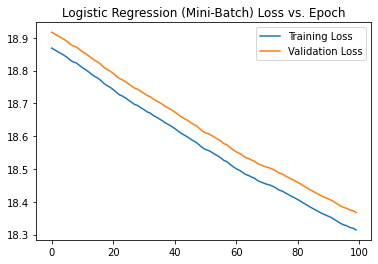

In [51]:
# Plot training and validation loss
plt.plot(list(range(100)), log_mb_train_loss[1:], label='Training Loss')
plt.plot(list(range(100)), log_mb_val_loss[1:], label='Validation Loss')
plt.title('Logistic Regression (Mini-Batch) Loss vs. Epoch')
plt.legend()
plt.show()

### Logistic Regression (Stochastic)

In [54]:
# Train model
log_s_w, log_s_train_loss, log_s_val_loss = fit_logistic_sgd(X_train_3, y_train_oh_3, X_val, y_val_oh, 10, 0.01, 0.01)

Epoch: 1

KeyboardInterrupt: ignored

<font color=maroon>For some reason, the model gets stuck on this portion will calculating cross entropy loss. The code does work without the loss, which is compiled below and ran for precision/recall metrics.

In [16]:
# Train model (without recording loss)
log_s_w = fit_logistic_sgd(X_train_3, y_train_oh_3, X_val, y_val_oh, 100, 0.01, 0.01)

Epoch: 100

In [17]:
# Make validation prediction
lg_s_val_pred = predict_logistic(X_val, log_s_w)

# Make testing prediction
lg_s_test_pred = predict_logistic(X_test, log_s_w)

In [18]:
# Validation report
print(classification_report(y_val, lg_s_val_pred))

              precision    recall  f1-score   support

           1       0.57      0.94      0.71      6071
           2       0.97      0.60      0.74      5920
           3       0.91      0.58      0.71      5980
           4       0.77      0.82      0.80      6029

    accuracy                           0.74     24000
   macro avg       0.80      0.74      0.74     24000
weighted avg       0.80      0.74      0.74     24000



In [19]:
print(confusion_matrix(y_val, lg_s_val_pred))

[[5720   92  120  139]
 [2055 3554   21  290]
 [1469    5 3458 1048]
 [ 833   20  217 4959]]


In [20]:
# Testing report
print(classification_report(y_test, lg_s_test_pred ))

              precision    recall  f1-score   support

           1       0.56      0.93      0.70      1900
           2       0.97      0.60      0.74      1900
           3       0.88      0.58      0.70      1900
           4       0.78      0.81      0.79      1900

    accuracy                           0.73      7600
   macro avg       0.80      0.73      0.73      7600
weighted avg       0.80      0.73      0.73      7600



In [21]:
print(confusion_matrix(y_test, lg_s_test_pred))

[[1776   33   45   46]
 [ 670 1137    9   84]
 [ 481    3 1103  313]
 [ 261    4   92 1543]]


### MLP

In [126]:
# Train model
network, hidden_weights, output_weights, mlp_train_loss, mlp_val_loss = fit_mlp(X_train_3, y_train_oh_3, X_val, y_val_oh, 100, 5, 0.01, 10)

Epoch: 10

In [127]:
# Print final losses
print(mlp_train_loss[-1])
print(mlp_val_loss[-1])

-0.6064674097955773
-0.6192262369202575


In [128]:
# Make validation prediction
mlp_val_pred = predict_mlp(X_val, hidden_weights, output_weights)

# Make testing prediction
mlp_test_pred = predict_mlp(X_test, hidden_weights, output_weights)

In [129]:
# Validation report
print(classification_report(y_val, mlp_val_pred))

              precision    recall  f1-score   support

           1       0.26      0.80      0.40      6071
           2       0.26      0.04      0.07      5920
           3       0.23      0.18      0.20      5980
           4       1.00      0.00      0.00      6029

    accuracy                           0.26     24000
   macro avg       0.44      0.25      0.17     24000
weighted avg       0.44      0.26      0.17     24000



In [130]:
print(confusion_matrix(y_val, mlp_val_pred))

[[4835  158 1078    0]
 [4306  238 1376    0]
 [4655  231 1094    0]
 [4531  281 1216    1]]


In [131]:
# Testing report
print(classification_report(y_test, mlp_test_pred ))

              precision    recall  f1-score   support

           1       0.27      0.81      0.40      1900
           2       0.31      0.05      0.08      1900
           3       0.24      0.19      0.21      1900
           4       0.00      0.00      0.00      1900

    accuracy                           0.26      7600
   macro avg       0.21      0.26      0.17      7600
weighted avg       0.21      0.26      0.17      7600



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [132]:
print(confusion_matrix(y_test, mlp_test_pred))

[[1548   48  304    0]
 [1350   90  460    0]
 [1471   63  366    0]
 [1435   86  379    0]]


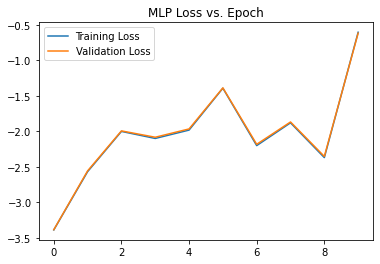

In [134]:
# Plot training and validation loss
plt.plot(list(range(10)), mlp_train_loss[1:], label='Training Loss')
plt.plot(list(range(10)), mlp_val_loss[1:], label='Validation Loss')
plt.title('MLP Loss vs. Epoch')
plt.legend()
plt.show()